# Lab 3: Iterative phase estimation

The quantum phase estimation (QPE) algorithm is one of the most important and famous quantum algorithms. It is a key subroutine of Shor's factoring algorithm, as well as algorithms for quantum simulation. The textbook version of the algorithm uses a number of auxiliary qubits which scales with the desired precision, leading to circuits that are challenging to execute on today's noisy devices with limited qubit number and connectivity.

Iterative phase estimation (IPE) is a variant of QPE which requires only one auxiliary qubit. In IPE, the auxiliary qubit is repeatedly measured, with the measurement results used to guide future quantum operations. Until the introduction of dynamic circuits, such classical feed-forward was impossible to execute on IBM's quantum hardware.

In this lab, we will use the recently introduced dynamic circuits capabilities to implement IPE.

## Background

Like any phase estimation algorithm, IPE is designed to solve the following problem:

**Problem statement:** Given a unitary matrix $U$ and an eigenstate $|\Psi\rangle$ of $U$ with an unknown eigenvalue $e^{i 2\pi \varphi}$, estimate the value of $\varphi$.

A few important details need to be clarified in this problem statement, namely, how $U$ and $|\Psi\rangle$ are specified. We assume that $U$ is given as a quantum circuit implementing $U$, and in fact, we assume we have the ability to efficiently implement the operations *controlled*-$U^{2^t}$ for positive integers $t$.
This is the same assumption used in the original QPE algorithm.
The eigenstate is also given as a quantum circuit: we assume we have the ability to efficiently prepare $|\Psi\rangle$.

Let's first assume for simplicity that $\varphi$ can have an exact binary expansion, that is, it can be written as
$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$
where in the final equality we are using "decimal" point notation in base 2.
For simplicity, suppose $U$ is a unitary operator acting on one qubit (everything we say here also applies to the case where $U$ acts on multiple qubits). Since IPE requires an auxiliary qubit, we need a system of two qubits, $q_0$ and $q_1$, where $q_0$ is the auxiliary qubit and $q_1$ represents the physical system on which $U$ operates.

Now, suppose that we initialize $q_0$ in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ and $q_1$ in the state $|\Psi \rangle$.
What happens if we apply the *controlled*-$U^{2^t}$ gate, with $q_0$ being the control and $q_1$ being the target?
Since $|\Psi \rangle$ is an eigenstate of $U$ with eigenvalue $e^{i 2\pi \varphi}$, we have
$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{\text{controlled-}U^{2^t}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$
That is, the state of the system qubit remains unchanged, while a phase of $e^{i 2 \pi 2^{t} \varphi}$ has been "kicked back" into the state of the auxiliary qubit.

Now, note that
$$
e^{i 2 \pi 2^{t} \varphi} = e^{i 2 \pi 2^{t} (0.\varphi_1 \varphi_2 \cdots \varphi_m)}
= e^{i 2 \pi (\varphi_1 \cdots \varphi_t . \varphi_{t + 1} \cdots \varphi_m)}
= e^{i 2 \pi (0. \varphi_{t + 1} \cdots \varphi_m)},
$$
where in the last equality, the whole number part of the "decimal" representation of the phase has disappeared because $e^{i 2\pi n} = 1$ for any integer $n$.
For example:
- for $t=0$, the phase would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$
- for $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$
- for $t=2$, the phase would be $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$
- for $t=m-1$, the phase would be $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$.

In the last case where $t = m - 1$, the phase is $e^{i 2 \pi 0.\varphi_m}$, which is equal to $1$ if $\varphi_m = 0$ and $-1$ if $\varphi_m = 1$.
In the first case, the auxiliary qubit $q_0$ would be in the state $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$, and in the second case it would be
in the state $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$. Therefore, measuring the qubit in the Pauli $X$ basis would distinguish these cases with a 100\% success rate.
This is done by performing a Hadamard gate on the qubit before measuring it. In the first case we would measure 0 and in the second case we would measure 1;
in other words, the measured bit would be equal to $\varphi_m$.

### The algorithm

In the first step of the IPE algorithm, we directly measure the least significant bit of the phase $\varphi$, $\varphi_m$, by initializing the 2-qubit registers as described above ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), performing a *controlled*-$U^{2^{m-1}}$ operation, and measuring $q_0$ in the Pauli $X$ basis.

in the second step, we initialize the systems in the same way and apply a *controlled*-$U^{2^{m-2}}$ operation. The relative phase in $q_0$ after these operations is now $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. 
To extract the phase bit $\varphi_{m-1}$, first perform a phase correction by rotating around the $Z$-axis by an angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. Perform a measurement on $q_0$ in the Pauli $X$ basis to obtain the phase bit $\varphi_{m-1}$. 

Therefore, the $k$-th step of the IPE, getting $\varphi_{m-k+1}$, consists of the register initialization ($q_0$ in $|+\rangle$, $q_1$ in $|\Psi\rangle$), the application of a *controlled*-$U^{2^{m-k}}$, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$, and a measurement of $q_0$ in the Pauli $X$ basis: a Hadamard transform to $q_0$, and a measurement of $q_0$ in the computational basis. Note that $q_1$ remains in the state $|\Psi\rangle$ throughout the algorithm.

## Implementation

In this lab, we will perform IPE on the single-qubit $S$-gate. The $S$ gate is given by the matrix

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

We will use the eigenstate $|\Psi\rangle = |1\rangle$, which has eigenvalue $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. So we have $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$. Since $\varphi$ can be represented exactly with 2 bits, our quantum circuit implementation will use a classical register with two bits to store the result.

The controlled-$S$ gate can be implemented using the controlled phase gate, available in Qiskit as `CPhaseGate`, which can also be applied by calling the `cp` method of a `QuantumCircuit`. The controlled phase gate is parameterized by an angle $\theta$ and has the matrix
$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


### Step 1

In the first step of the algorithm, we measure the least significant bit of $\varphi$.

#### Exercise 1

Obtain the least significant bit of $\varphi$ by performing the following steps:
1. Initialize the qubits:
   - Apply a Hadamard on the auxiliary qubit.
   - Apply an X gate on the system qubit to put it in the $|1\rangle$ state.
2. Apply a *controlled*-$S^{2}$ gate by applying a `CPhaseGate` with the appropriate angle.
3. Measure the auxiliary qubit in the $X$ basis:
   - Apply a Hadamard gate on the auxiliary qubit.
   - Measure it in the computational basis.

The resulting circuit should look something like this:

![step1-circuit](resources/step1-circuit.png)

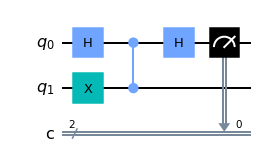

In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    qc.h(qr[0])#Step 1.1: Apply Hadamard gate on the auxiliar qubit
    qc.x(qr[1])# Step 1.2: apply x gate on the system qubit
    qc.cz(qr[0],qr[1])# Step 2: Note that S^2=Z, hence we just want a controlled Z
    qc.h(qr[0]) # Step 3.1: Apply Hadamard gate to the auxiliar quibit
    qc.measure(qr[0],cr[0])# Step 3.2: Measure the auxiliar quibit and store the result in the classical register 
    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

In [8]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3a

grade_ex3a(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Step 2

In the first step, we measured the least significant bit $\varphi_2$. In the second (and final) step, we extract the next bit $\varphi_1$, which will involve applying a phase correction to cancel out the phase contribution from $\varphi_2$. The phase correction depends on the value of the classical register holding $\varphi_2$. We need dynamic circuits to perform this classical feedback! The phase correction can be applied using `PhaseGate` or by directly calling the `p` method of a QuantumCircuit.

#### Exercise 2

In this exercise, we begin with the circuit from Step 1, which you should have constructed in Exercise 1.

Obtain the next bit of $\varphi$ by performing the following steps:
1. Reset and re-initialize the auxiliary qubit.
2. Apply the controlled unitary gate.
3. Measure the auxiliary qubit in the $X$ basis.

The resulting circuit should look something like this:

![step1-circuit](resources/step2-circuit.png)

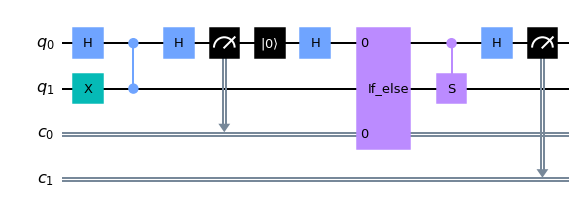

In [5]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)

    ####### your code goes here #######
    
    qc.reset(qr[0])# Step 1.1: Reset the auxiliary qubit
    qc.h(qr[0]) # Step 1.2: Initialize the auxiliary qubit
    with qc.if_test((cr[0],1)): 
        qc.sdg(qr[0])# Step 1.3: Phase correction by rotation round z axis by -pi/2
    qc.cs(qr[0],qr[1]) # Step 2: Apply corresponding unitary operator
    qc.h(qr[0]) # We change to the X basis.
    qc.measure(qr[0],cr[1]) #Step 3: Measure in the X basis
    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

In [39]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3b

grade_ex3b(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Run on simulator

Now that we have the complete circuit, let's first run it on a local simulator.

In [3]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

If your circuit is correct, you should have gotten the bitstring `01` with 100% probability. This value corresponds to the phase written in binary as $\varphi = 0.01 = 1/4$. Indeed, this is the correct phase!

### Exercise 3

Construct an IPE circuit to estimate the phase of the T gate, whose matrix is given by

$$ T =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 4}
\end{pmatrix}$$

How many bits are needed to represent the phase in this case?

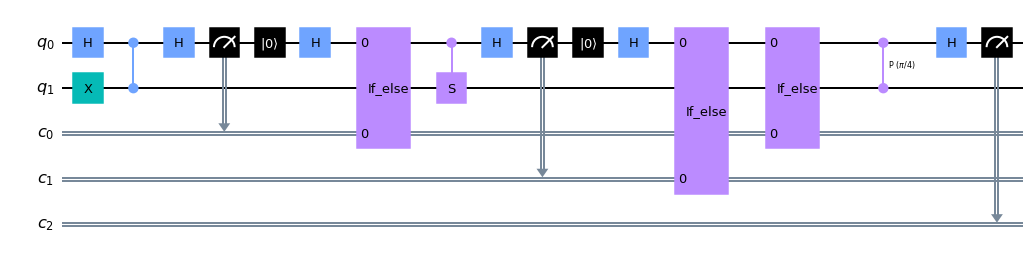

In [6]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    
    ## Obtaining the first digit of the phase
    qc.h(qr[0])
    qc.x(qr[1])
    
    qc.cz(qr[0],qr[1])# Corresponding unitary operator. Recall that T^4=Z
    
    qc.h(qr[0])
    
    qc.measure(qr[0],cr[0])#Measurement
    
    qc.reset(qr[0])
    
    qc.h(qr[0])
    
    with qc.if_test((cr[0],1)):
        qc.sdg(qr[0])# Phase correction with rotation around the z-axis by an angle of -pi/2
    
    # Obtaining the second digit of the phase
    qc.cs(qr[0],qr[1])#Corresponding unitary operator. Recall that T^2=S
    
    qc.h(qr[0])
    
    qc.measure(qr[0],cr[1])#Measurement
    
    qc.reset(qr[0])
    
    qc.h(qr[0])
    
    with qc.if_test((cr[1],1)):
        qc.sdg(qr[0])# Phase correction with rotation around the z-axis by an angle of -pi/2
        
    with qc.if_test((cr[0],1)):
        qc.tdg(qr[0])#Phase correction with rotation around the z-axis by an angle of -pi/4
    
    
    qc.cp(np.pi/4,qr[0],qr[1])#Corresponding unitary operator.  
    
    qc.h(qr[0])
    
    qc.measure(qr[0],cr[2])#Measurement
    
    
    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [7]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'001': 1000}

In [73]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3c

grade_ex3c(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### When the phase does not have an exact binary expansion

Let's consider the case when the phase does not have an exact binary expansion, for example, $\varphi = 1/3$.
In this case, the single-qubit gate has the unitary

$$ U =
\begin{pmatrix}
1 & 0\\
0 & e^{i2\pi / 3}
\end{pmatrix}
$$

The angle $\varphi = 1/3$ does not have an exact finite binary expansion. In contrast, it has the infinite binary expansion

$$
1/3 = 0.010101\ldots
$$

In practice we work with a fixed number of bits of precision, so our goal is to obtain the closest value that can be represented with those bits. In the following example, we will use two bits of precision. In this case, the closest value is $0.01 = 1/4$. Because this value does not represent the exact phase, there is some probability that we will obtain a different, less precise result.

In the following code cells, we construct and simulate an IPE circuit to measure the phase of this gate.

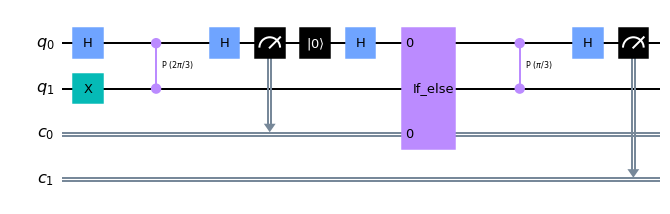

In [8]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [9]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'10': 56, '11': 49, '01': 706, '00': 189}
Success probability: 0.706


As you can see, this time, we are not guaranteed to obtain the desired result. A natural question to ask is: How can we boost the success probability?

One way that the algorithm fails is that the first measured bit is incorrect. In this case, the phase correction applied before measuring the second bit is also incorrect, causing the rest of the bits to be likely incorrect as well. A simple way to mitigate this problem is to repeat the measurement of the first few bits several times and take a majority vote to increase the likelihood that we measure the bit correctly. Implementing this procedure within a single circuit requires performing arithmetic on the measured outcomes. Due to a temporary limitation in Qiskit, it is currently not possible to perform arithmetic on measured bits and condition future circuit operations on the results. So, here we will measure each bit using separate circuits.

The following code cells construct and simulate an IPE circuit for measuring just the first bit of the phase.

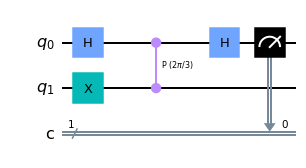

In [10]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [12]:
job = sim.run(qc, shots=15)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 3, '1': 12}


Hopefully, the correct bit was measured more often than not.

### Exercise 4

Examine the counts dictionary from the output of the last code cell. What is the correct value for the first bit? Was it measured more often than not? If not, rerun the last code cell until it is. Then, write some code in the code cell below that sets the variable `step1_bit` equal to the value of the bit that was measured the majority of the time.

In [13]:
step1_bit: int

####### your code goes here #######
step1_bit=1
print(step1_bit)

1


In [85]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3d

grade_ex3d(step1_bit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Exercise 5

Now construct the circuit to measure the second bit of the phase. Replace the first stage of the circuit with one which simply sets the auxiliary bit to the value we measured above, so that we always measure the correct value for the first bit of the phase.

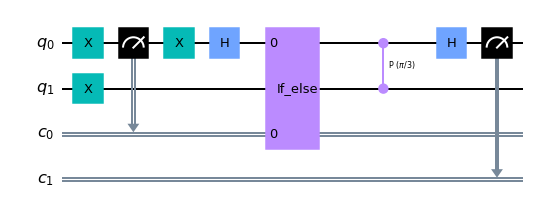

In [14]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)
    
    ####### your code goes here #######
    #initialization
    qc.x(qr[0])#This forces the measure of cr[0] to be 1
    qc.measure(qr[0],cr[0])
    qc.x(qr[0])# We reset qr[0]
    
    qc.x(qr[1])
    qc.h(qr[0])
    #Apply control-U operator as many times as needed to get the second-least significant phase bit
    with qc.if_test((cr[0],1)):
        qc.sdg(qr[0])# Corresponding rotation about the z-axis by an angle of -pi/2
    qc.cp(np.pi/3,qr[0],qr[1])# Applying U
    
    # Measure the auxiliary qubit in x-basis
    qc.h(qr[0])
    
    qc.measure(qr[0],cr[1])
    
    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [123]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3e

grade_ex3e(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [124]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'11': 64, '01': 936}
Success probability: 0.936


Now, the success probability is much higher than before!

## Run on hardware

In the final part of this lab, we will run some circuits on real hardware! The code cells below initialize and run the circuit you created in Exercise 2 to measure the phase of the $S$ gate. Because current quantum hardware suffers from noise, the results will not be as good as what you got on the simulator. Feel free to try running the other circuits you created in this lab, though be aware that larger circuits, like the one from Exercise 3 for measuring the phase of the $T$ gate, will suffer from even more noise.

In [126]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

In [127]:
hub = "qc-spring-23-2" # YOUR HUB
group = "group-5" # YOUR GROUP
project = "rec6zicggmdxxkpcb"

backend_name = "ibm_peekskill"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [128]:
from qiskit import transpile

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc_transpiled = transpile(qc, backend)

In [129]:
job = backend.run(qc_transpiled, shots=1000, dynamic=True)
job_id = job.job_id()
print(job_id)

chjrksaae4cj9gaqj180


In [131]:
retrieve_job = provider.retrieve_job(job_id)
retrieve_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
from qiskit.tools.visualization import plot_histogram

counts = retrieve_job.result().get_counts()
plot_histogram(counts)

This lab was adapted from the [Qiskit Textbook lab](https://learn.qiskit.org/course/ch-labs/lab-6-iterative-phase-estimation-algorithm) on iterative phase estimation as well as material from the [dynamic circuits documentation](https://quantum-computing.ibm.com/services/resources/docs/resources/manage/systems/dynamic-circuits/Getting-started-with-Dynamic-Circuits).